In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
from WM2 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

## Count up and maintain result in WM

In [88]:
stimuli = np.random.RandomState(seed=0).randint(0,2,size=21)
stimuli = 2*stimuli - 1
func_stim = lambda t: stimuli[int(t)] if t%1<0.5 else 0

network = nengo.Network(seed=0)
with network:
    node_stim = nengo.Node(func_stim)
    
    ens_stim = nengo.Ensemble(1000, 1)
    ens_delta = nengo.Ensemble(1000, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0,1))
    ens_memory = nengo.Ensemble(2000, 1)
    ens_number = nengo.Ensemble(2000, 1, radius=20)
    
    conn_stim = nengo.Connection(node_stim, ens_stim)
    conn_delta1 = nengo.Connection(ens_stim, ens_delta, synapse=0.01, function=lambda x: 2*np.abs(x))
    conn_delta2 = nengo.Connection(ens_stim, ens_delta, synapse=0.1, function=lambda x: -2*np.abs(x))
    conn_memff = nengo.Connection(ens_delta, ens_memory, synapse=0.2, transform=0.05)
    conn_memfb = nengo.Connection(ens_memory, ens_memory, synapse=0.2)
    conn_num = nengo.Connection(ens_memory, ens_number, transform=25, synapse=0.1)
    
    probe_stim = nengo.Probe(ens_stim, synapse=0.01)
    probe_delta = nengo.Probe(ens_delta, synapse=0.01)
    probe_memory = nengo.Probe(ens_memory, synapse=0.01)
    probe_number = nengo.Probe(ens_number, synapse=0.01)
sim = nengo.Simulator(network, dt=0.001)
with sim:
    sim.run(20)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

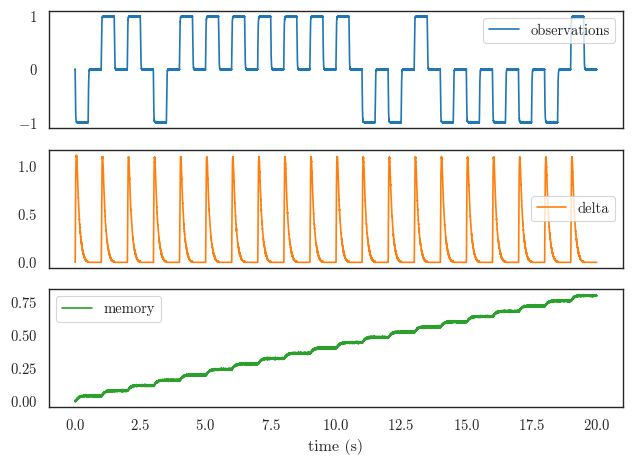

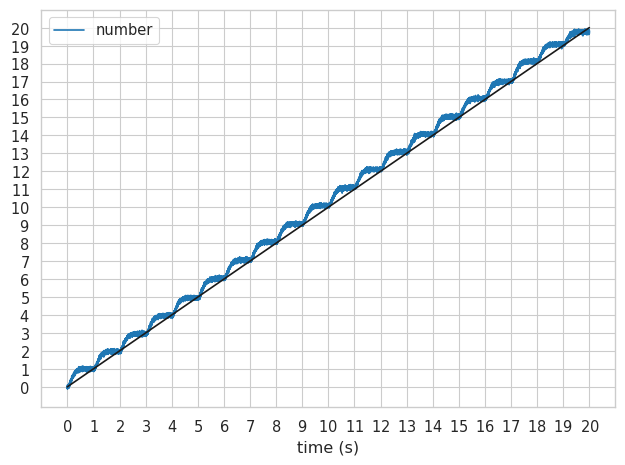

In [89]:
fig, axes = plt.subplots(nrows=3, sharex=True)
sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_stim].flatten(), label='observations', color=palette[0], ax=axes[0])
sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_delta].flatten(), label='delta', color=palette[1], ax=axes[1])
sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_memory].flatten(), label='memory', color=palette[2], ax=axes[2])
axes[-1].set(xlabel='time (s)')
fig.tight_layout()

with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=1, sharex=True)
    sns.lineplot(x=sim.trange().flatten(), y=sim.data[probe_number].flatten(), label='number', color=palette[0], ax=axes)
    sns.lineplot(x=np.arange(0, 21, 1), y=np.arange(0, 21, 1), color='k')
    axes.set(xlabel='time (s)', xticks=np.arange(0, 21, 1), yticks=np.arange(0, 21, 1))
    plt.grid(True, axis='y')  # Enable only y-axis gridlines
    fig.tight_layout()

## Test utility of Alpha synapse for delay

In [166]:
stimuli = np.random.RandomState(seed=0).randint(0,2,size=21)
stimuli = 2*stimuli - 1
func_stim = lambda t: stimuli[int(t)] if t%1<0.5 else 0

network = nengo.Network(seed=0)

with network:
    node_stim = nengo.Node(func_stim)
    
    ens_stim = nengo.Ensemble(1000, 1)
    ens_combined = nengo.Ensemble(2000, 2)
    ens_diff = nengo.Ensemble(2000, 1, radius=0.5)
    ens_memory = nengo.Ensemble(2000, 1, radius=2)

    conn_stim = nengo.Connection(node_stim, ens_stim, synapse=None)
    conn_comb1 = nengo.Connection(ens_stim, ens_combined[0], synapse=0.01)
    conn_comb2 = nengo.Connection(ens_memory, ens_combined[1], synapse=nengo.synapses.Alpha(0.1))
    conn_ff = nengo.Connection(ens_combined[0], ens_diff, synapse=0.01)
    conn_diff1 = nengo.Connection(ens_diff, ens_memory, synapse=0.05, transform=10)
    conn_diff2 = nengo.Connection(ens_memory, ens_diff, synapse=0.01, transform=-1)
    conn_mem = nengo.Connection(ens_memory, ens_memory, synapse=0.1)

    probe_stim = nengo.Probe(ens_stim, synapse=0.01)
    probe_memory = nengo.Probe(ens_memory, synapse=0.01)
    probe_combined = nengo.Probe(ens_combined, synapse=0.01)
    probe_diff = nengo.Probe(ens_diff, synapse=0.01)

sim = nengo.Simulator(network, dt=0.001)
with sim:
    sim.run(3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

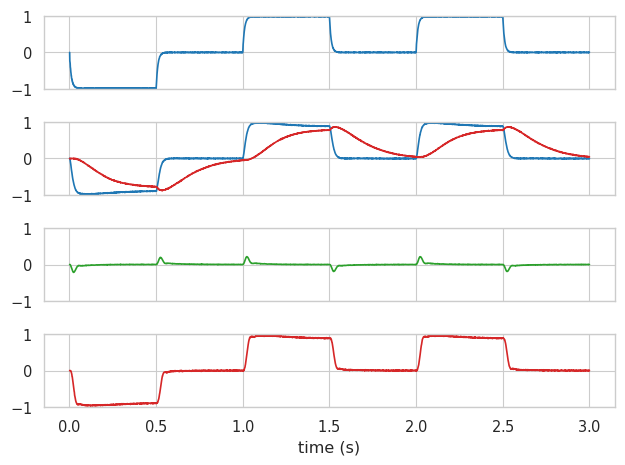

In [167]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=4, sharex=True, sharey=True)
    axes[0].plot(sim.trange().flatten(), sim.data[probe_stim].flatten(), label='observations', color=palette[0])
    axes[1].plot(sim.trange(), sim.data[probe_combined][:,0], label='combined (input)', color=palette[0])
    axes[1].plot(sim.trange(), sim.data[probe_combined][:,1], label='combined (feedback from memory)', color=palette[3])
    axes[2].plot(sim.trange().flatten(), sim.data[probe_diff].flatten(), label='diff', color=palette[2])
    axes[3].plot(sim.trange().flatten(), sim.data[probe_memory].flatten(), label='memory', color=palette[3])
    axes[-1].set(xlabel='time (s)', ylim=(-1,1))
    fig.tight_layout()

## Compute 1/x

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

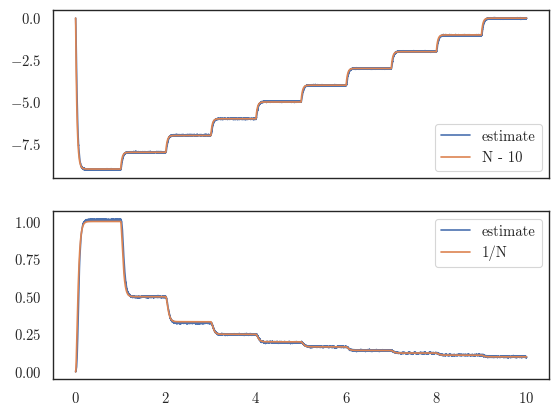

In [55]:
stimuli = np.random.RandomState(seed=0).randint(0,2,size=21)
stimuli = 2*stimuli - 1

network = nengo.Network(seed=1111)

func_stim2 = lambda t: stimuli[int(t)]
func_number = lambda t: int(t+1)
func_inverse = lambda x: 1/(x+10)
func_center = lambda x: x-10

encoders = nengo.dists.Choice([[1]])
intercepts = nengo.dists.Uniform(0.0, 1)
eval_points = np.linspace(-1, 1, 1000).reshape(-1,1)

with network:
    node_stim = nengo.Node(func_stim2)
    node_number = nengo.Node(func_number)
    node_centered = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
    node_weight = nengo.Ensemble(1, 1, neuron_type=nengo.Direct(), encoders=encoders, intercepts=intercepts)

    ens_stim = nengo.Ensemble(1000, 1)
    ens_number = nengo.Ensemble(1000, 1, radius=20)
    ens_centered = nengo.Ensemble(1000, 1, radius=11)
    ens_weight = nengo.Ensemble(1000, 1, radius=0.9)

    conn_stim = nengo.Connection(node_stim, ens_stim)
    conn_num = nengo.Connection(node_number, ens_number)
    conn_center = nengo.Connection(ens_number, ens_centered, synapse=0.01, function=func_center)
    conn_weight = nengo.Connection(ens_centered, ens_weight, synapse=0.03, function=func_inverse, eval_points=eval_points)
    conn_center_p = nengo.Connection(node_number, node_centered, synapse=None, function=func_center)
    conn_weight_p = nengo.Connection(node_centered, node_weight, synapse=0.03, function=func_inverse, eval_points=eval_points)
    
    probe_stim = nengo.Probe(ens_stim, synapse=0.03)
    probe_number = nengo.Probe(ens_number, synapse=0.03)
    probe_centered = nengo.Probe(ens_centered, synapse=0.03)
    probe_weight = nengo.Probe(ens_weight, synapse=0.03)
    probe_centered_p = nengo.Probe(node_centered, synapse=0.03)
    probe_weight_p = nengo.Probe(node_weight, synapse=0.03)

sim = nengo.Simulator(network, dt=0.001)
with sim:
    sim.run(10)
    
fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(sim.trange(), sim.data[probe_centered], label='estimate')
axes[0].plot(sim.trange(), sim.data[probe_centered_p], label='N - 10')
axes[1].plot(sim.trange(), sim.data[probe_weight], label='estimate')
axes[1].plot(sim.trange(), sim.data[probe_weight_p], label='1/N')
axes[0].legend()
axes[1].legend()
plt.show()

### No Centering

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

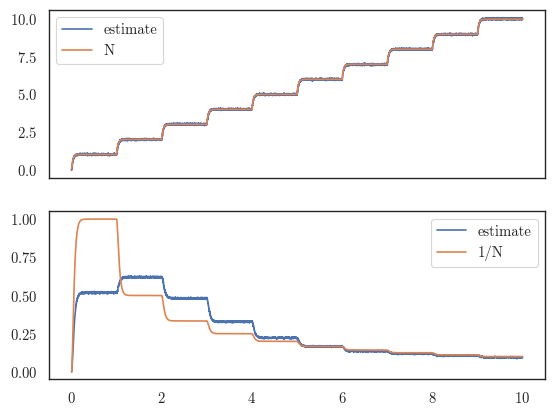

In [29]:
network = nengo.Network(seed=1)

func_stim2 = lambda t: stimuli[int(t)]
func_number = lambda t: int(t+1)
func_inverse = lambda x: 1/x if np.abs(x)>0.1 else 1

encoders = nengo.dists.Choice([[1]])
intercepts = nengo.dists.Uniform(0.0, 1)
eval_points = np.linspace(0.0, 1, 1000).reshape(-1,1)

with network:
    node_stim = nengo.Node(func_stim2)
    node_number = nengo.Node(func_number)
    node_weight = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

    ens_stim = nengo.Ensemble(1000, 1)
    ens_number = nengo.Ensemble(1000, 1, radius=20)
    ens_weight = nengo.Ensemble(1000, 1, encoders=encoders, intercepts=intercepts)

    conn_stim = nengo.Connection(node_stim, ens_stim)
    conn_num = nengo.Connection(node_number, ens_number)
    conn_weight = nengo.Connection(ens_number, ens_weight, synapse=0.03, function=func_inverse)
    conn_weight_p = nengo.Connection(node_number, node_weight, synapse=0.03, function=func_inverse)
    
    probe_stim = nengo.Probe(ens_stim, synapse=0.03)
    probe_number = nengo.Probe(ens_number, synapse=0.03)
    probe_number_p = nengo.Probe(node_number, synapse=0.03)
    probe_weight = nengo.Probe(ens_weight, synapse=0.03)
    probe_weight_p = nengo.Probe(node_weight, synapse=0.03)

sim = nengo.Simulator(network, dt=0.001)
with sim:
    sim.run(10)

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(sim.trange(), sim.data[probe_number], label='estimate')
axes[0].plot(sim.trange(), sim.data[probe_number_p], label='N')
axes[1].plot(sim.trange(), sim.data[probe_weight], label='estimate')
axes[1].plot(sim.trange(), sim.data[probe_weight_p], label='1/N')
axes[0].legend()
axes[1].legend()
plt.show()

## Update WM with buffers

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

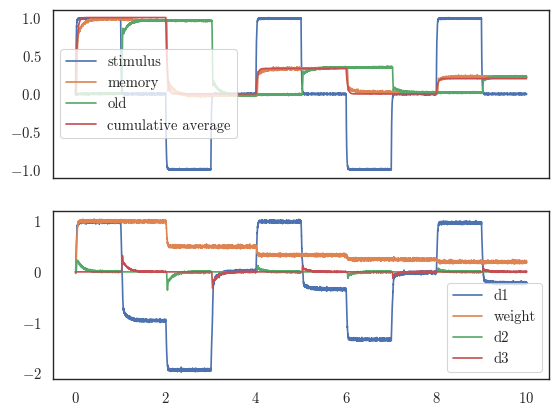

In [12]:
rng = np.random.RandomState(seed=5)
t_show = 1.0
t_buffer = 1.0
T = t_show + t_buffer
stimuli3 = [1 if rng.rand()<0.5 else -1 for i in range(11)]

func_stim3 = lambda t: stimuli3[int(t/T)] if t%T<t_show else 0
func_stop = lambda t: 0 if t%T<t_show else 1
func_number = lambda t: int(t/T)+1
func_multiply = lambda x: x[0]*x[1]
func_inverse = lambda x: 1/x if x>0 else 1
func_cumavg = lambda t: np.sum(stimuli3[:int(t/T)+1])/(int(t/T)+1)

w_stop = -10*np.ones((1000, 1))

network = nengo.Network(seed=0)
with network:
    node_stim = nengo.Node(func_stim3)
    node_stop = nengo.Node(func_stop)
    node_number = nengo.Node(func_number)
    node_inverse = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
    node_cumavg = nengo.Node(func_cumavg)

    ens_stim = nengo.Ensemble(1000, 1)
    # ens_d1 = nengo.Ensemble(1000, 1)
    ens_d1 = nengo.Ensemble(2000, 2, radius=3)
    ens_d2 = nengo.Ensemble(1000, 1)
    ens_d3 = nengo.Ensemble(1000, 1)
    ens_memory = nengo.Ensemble(1000, 1)
    ens_old = nengo.Ensemble(1000, 1)
    ens_stop = nengo.Ensemble(1000, 1)

    nengo.Connection(node_stim, ens_stim, synapse=None)
    nengo.Connection(node_stop, ens_stop, synapse=None)
    nengo.Connection(node_number, node_inverse, function=func_inverse)

    nengo.Connection(ens_stim, ens_d1[0], synapse=0.01)
    nengo.Connection(node_inverse, ens_d1[1], synapse=0.01)
    nengo.Connection(ens_d1, ens_d2, synapse=0.01, function=func_multiply)
    nengo.Connection(ens_old, ens_d1[0], synapse=0.01, transform=-1)

    nengo.Connection(ens_d2, ens_memory, synapse=0.01, transform=3)
    nengo.Connection(ens_memory, ens_memory, synapse=0.1)
    nengo.Connection(ens_memory, ens_d2, synapse=0.01, transform=-1)
    nengo.Connection(ens_old, ens_d2, synapse=0.01)

    nengo.Connection(ens_memory, ens_d3, synapse=0.01)
    nengo.Connection(ens_d3, ens_old, synapse=0.01, transform=3)
    nengo.Connection(ens_old, ens_d3, synapse=0.01, transform=-1)
    nengo.Connection(ens_old, ens_old, synapse=0.1)
    
    nengo.Connection(node_stop, ens_d2.neurons, synapse=0.01, transform=w_stop)
    nengo.Connection(node_stop, ens_d3.neurons, synapse=0.01, transform=w_stop, function=lambda x: 1-x)

    probe_stim = nengo.Probe(ens_stim, synapse=0.01)
    probe_stop = nengo.Probe(ens_stop, synapse=0.01)
    probe_d1 = nengo.Probe(ens_d1, synapse=0.01)
    probe_d2 = nengo.Probe(ens_d2, synapse=0.01)
    probe_d3 = nengo.Probe(ens_d3, synapse=0.01)
    probe_memory = nengo.Probe(ens_memory, synapse=0.01)
    probe_old = nengo.Probe(ens_old, synapse=0.01)
    probe_cumavg_p = nengo.Probe(node_cumavg, synapse=0.03)

with nengo.Simulator(network) as sim:
    sim.run(T*5)

fig, axes = plt.subplots(nrows=2, sharex=True, sharey=False)
axes[0].plot(sim.trange(), sim.data[probe_stim], label='stimulus')
# axes[0].plot(sim.trange(), 0.2*sim.data[probe_stop], label='stop')
axes[0].plot(sim.trange(), sim.data[probe_memory], label='memory')
axes[0].plot(sim.trange(), sim.data[probe_old], label='old')
axes[0].plot(sim.trange(), sim.data[probe_cumavg_p], label='cumulative average')
axes[1].plot(sim.trange(), sim.data[probe_d1][:,0], label='d1')
axes[1].plot(sim.trange(), sim.data[probe_d1][:,1], label='weight')
axes[1].plot(sim.trange(), sim.data[probe_d2], label='d2')
axes[1].plot(sim.trange(), sim.data[probe_d3], label='d3')
axes[0].legend()
axes[1].legend()
# axes[2].legend()
plt.show()

## Put it all together
#### Count up, calculate 1/N from result, and use 1/N as weight
#### Also add inhibitory populations to stop update during buffer phase, 
#### And an external input for additive weight from RD

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

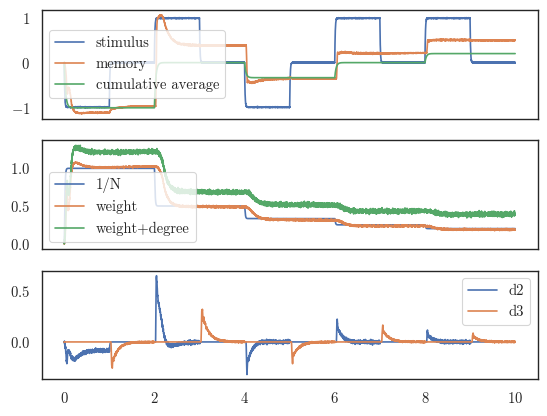

In [67]:
seed = 6
rng = np.random.RandomState(seed=seed)
network = nengo.Network(seed=seed)

t_show = 1.0
t_buffer = 1.0
T = t_show + t_buffer
stimuli3 = [1 if rng.rand()<0.5 else -1 for i in range(11)]
degree = 0.0

encoders = nengo.dists.Choice([[1]])
intercepts = nengo.dists.Uniform(0.0, 1)
eval_points = np.linspace(-1, 1, 1000).reshape(-1,1)

func_stim3 = lambda t: stimuli3[int(t/T)] if t%T<t_show else 0
func_number = lambda t: int(t/T)+1
func_multiply = lambda x: x[0]*x[1]
func_inverse = lambda x: 1/(x+10)
func_center = lambda x: x-10
func_stop2 = lambda x: 0 if np.abs(x)>0.1 else 1
func_stop3 = lambda x: 1 if np.abs(x)>0.1 else 0
func_inverse_p = lambda x: 1/x if x>0 else 1
func_cumavg = lambda t: np.sum(stimuli3[:int(t/T)+1])/(int(t/T)+1)
func_degree = lambda t: degree

w_stop = -10*np.ones((1000, 1))

with network:
    # inputs
    node_stim = nengo.Node(func_stim3)
    node_degree = nengo.Node(func_degree)
    
    # neural populations
    ens_stim = nengo.Ensemble(1000, 1)
    ens_differentiator = nengo.Ensemble(1000, 1, encoders=encoders, intercepts=intercepts)
    ens_number_memory = nengo.Ensemble(2000, 1)
    ens_number = nengo.Ensemble(1000, 1, radius=20)
    ens_centered = nengo.Ensemble(1000, 1, radius=11)
    ens_weight = nengo.Ensemble(1000, 1, radius=0.9)
    ens_degree = nengo.Ensemble(1000, 1)
    ens_d1 = nengo.Ensemble(2000, 2, radius=3)
    ens_d2 = nengo.Ensemble(1000, 1)
    ens_d3 = nengo.Ensemble(1000, 1)
    ens_memory = nengo.Ensemble(1000, 1)
    ens_old = nengo.Ensemble(1000, 1)
    ens_stop2 = nengo.Ensemble(1000, 1, encoders=encoders, intercepts=intercepts)
    ens_stop3 = nengo.Ensemble(1000, 1, encoders=encoders, intercepts=intercepts)

    # input signals
    nengo.Connection(node_stim, ens_stim, synapse=None)
    nengo.Connection(node_degree, ens_degree, synapse=None)
    
    # count up based on changes in the input signals
    nengo.Connection(ens_stim, ens_differentiator, synapse=0.01, function=lambda x: 2*np.abs(x))
    nengo.Connection(ens_stim, ens_differentiator, synapse=0.1, function=lambda x: -2*np.abs(x))
    nengo.Connection(ens_differentiator, ens_number_memory, synapse=0.2, transform=0.05)
    nengo.Connection(ens_number_memory, ens_number_memory, synapse=0.2)
    nengo.Connection(ens_number_memory, ens_number, transform=25, synapse=0.1)

    # compute weight = 1/N from number memory
    nengo.Connection(ens_number, ens_centered, synapse=0.01, function=func_center)
    nengo.Connection(ens_centered, ens_weight, synapse=0.03, function=func_inverse, eval_points=eval_points)
    # nengo.Connection(node_weight, ens_weight, synapse=0.01)

    # compute error between current observation and WM value stored in "old" buffer  
    # then pass that error, times the current weight, to D2
    # also add degree into current weight, as represented in D1
    nengo.Connection(ens_stim, ens_d1[0], synapse=0.01)
    nengo.Connection(ens_weight, ens_d1[1], synapse=0.01)
    nengo.Connection(ens_d1, ens_d2, synapse=0.01, function=func_multiply)
    nengo.Connection(ens_old, ens_d1[0], synapse=0.01, transform=-1)
    nengo.Connection(ens_degree, ens_d1[1], synapse=0.01)
    
    # update the WM value stored in the "memory" buffer according to the error passed to D2
    # and the stable WM value stored in the "old" buffer
    nengo.Connection(ens_d2, ens_memory, synapse=0.01, transform=3)
    nengo.Connection(ens_memory, ens_memory, synapse=0.1)
    nengo.Connection(ens_memory, ens_d2, synapse=0.01, transform=-1)
    nengo.Connection(ens_old, ens_d2, synapse=0.01)

    # update the value in "old" to the value in "memory" 
    nengo.Connection(ens_memory, ens_d3, synapse=0.01)
    nengo.Connection(ens_d3, ens_old, synapse=0.01, transform=3)
    nengo.Connection(ens_old, ens_d3, synapse=0.01, transform=-1)
    nengo.Connection(ens_old, ens_old, synapse=0.1)

    # alternatively updates "memory" and "old":
    # the former is updated while the simulus is present,
    # and the latter is updated during the inter-stimulus interval
    nengo.Connection(ens_stim, ens_stop2, synapse=0.01, function=func_stop2)
    nengo.Connection(ens_stim, ens_stop3, synapse=0.01, function=func_stop3)
    nengo.Connection(ens_stop2, ens_d2.neurons, synapse=0.01, transform=w_stop)
    nengo.Connection(ens_stop3, ens_d3.neurons, synapse=0.01, transform=w_stop)

    # probes to decode neural activity into represented quantities
    probe_stim = nengo.Probe(ens_stim, synapse=0.01)
    probe_stop2 = nengo.Probe(ens_stop2, synapse=0.01)
    probe_stop3 = nengo.Probe(ens_stop3, synapse=0.01)
    probe_weight = nengo.Probe(ens_weight, synapse=0.01)
    probe_d1 = nengo.Probe(ens_d1, synapse=0.01)
    probe_d2 = nengo.Probe(ens_d2, synapse=0.01)
    probe_d3 = nengo.Probe(ens_d3, synapse=0.01)
    probe_memory = nengo.Probe(ens_memory, synapse=0.01)
    probe_old = nengo.Probe(ens_old, synapse=0.01)

    # ground truth calculation, for comparison
    node_number = nengo.Node(func_number)
    node_weight = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
    node_cumavg = nengo.Node(func_cumavg)
    nengo.Connection(node_number, node_weight, function=func_inverse_p)
    probe_cumavg_p = nengo.Probe(node_cumavg, synapse=0.03)
    probe_weight_p = nengo.Probe(node_weight, synapse=0.01)

with nengo.Simulator(network) as sim:
    sim.run(T*5)

fig, axes = plt.subplots(nrows=3, sharex=True, sharey=False)
axes[0].plot(sim.trange(), sim.data[probe_stim], label='stimulus')
# axes[0].plot(sim.trange(), 0.2*sim.data[probe_stop], label='stop')
axes[0].plot(sim.trange(), sim.data[probe_memory], label='memory')
# axes[0].plot(sim.trange(), sim.data[probe_old], label='old')
axes[0].plot(sim.trange(), sim.data[probe_cumavg_p], label='cumulative average')
axes[1].plot(sim.trange(), sim.data[probe_weight_p], label='1/N')
axes[1].plot(sim.trange(), sim.data[probe_weight], label='weight')
axes[1].plot(sim.trange(), sim.data[probe_d1][:,1], label='weight+degree')
axes[2].plot(sim.trange(), sim.data[probe_d2], label='d2')
axes[2].plot(sim.trange(), sim.data[probe_d3], label='d3')
axes[0].legend()
axes[1].legend()
axes[2].legend()
plt.show()

## Check WM2.py version is working

In [6]:
env = Environment(sid=1, trial=1)
net, sim = simulate_WM(env, z=0.3, seed_sim=0, seed_net=0, progress_bar=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

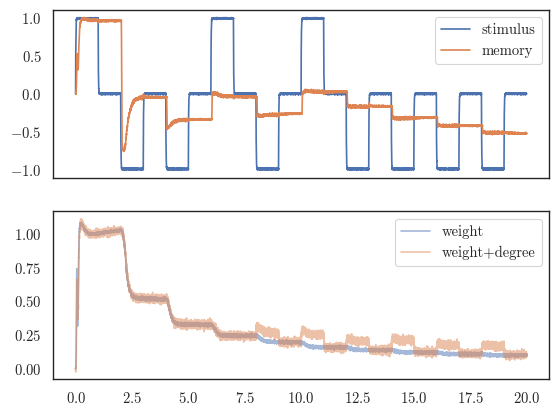

In [9]:
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=False)
axes[0].plot(sim.trange(), sim.data[net.probe_stim], label='stimulus')
axes[0].plot(sim.trange(), sim.data[net.probe_memory], label='memory')
axes[1].plot(sim.trange(), sim.data[net.probe_weight], label='weight', alpha=0.5)
axes[1].plot(sim.trange(), sim.data[net.probe_d1][:,1], label='weight+degree', alpha=0.5)
axes[0].legend()
axes[1].legend()
plt.show()